In [ ]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML

from langdetect import detect
import re

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

Version:      2.4.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7

In [5]:
VAL_FRACTION = 0.25

In [6]:
MIN_COMMENT_LEN = 25

In [7]:
TOP_N = 5

## GET DATA

In [8]:
def get_hot_data():
    hot = requests.get("https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame").content.decode()
  
    # Parsing the XML file
    xmlparse = Xet.fromstring(hot)

    hot_array = []
    for item in xmlparse:
        dict_element = {
            "id": item.get("id"),
            "rank": item.get("rank")
        }
        for option in item:
            dict_element[option.tag] = option.get("value")
        hot_array.append(dict_element)
    return hot_array

In [9]:
def get_comments(id_array, verbose=1):
    max_comments_per_page = 1
    array_ids = [h['id'] for h in id_array]
    ids = ','.join(array_ids)
    page_size = 100
    page_number = 0
    comments_array = []

    while max_comments_per_page > 0 and len(array_ids) > 0:
        page_number += 1
        if verbose>0 and page_number%verbose==0:
            print(f"page number = {page_number}", end=" ")
        comments = requests.get(f"https://www.boardgamegeek.com/xmlapi2/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

        # Parsing the XML file
        xmlparse = Xet.fromstring(comments)
        comments_per_item = []
        for item in xmlparse:        
            for option in item:
                if option.tag == 'comments':
                    comments_per_page = 0
                    for comment in option:
                        comments_per_page += 1
                        dict_element = {
                            "id": item.get("id"),
                            "username": comment.get("username"),
                            "rating": comment.get("rating"),
                            "value": comment.get("value")
                        }
                        comments_array.append(dict_element)
                    if comments_per_page==0:
                        array_ids.remove(item.get("id"))
                        ids = ','.join(array_ids)
                    comments_per_item.append(comments_per_page)
        max_comments_per_page = max(comments_per_item)
        if verbose>0 and page_number%verbose==0:
            print(f"(max: {max(comments_per_item)}, len: {len(comments_per_item)})")
    comments_df = pd.DataFrame(comments_array)
    print(f"comments_df shape: {comments_df.shape}")
    return comments_df

In [10]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '285192',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/oaD1ZQ3yGj6lacLdtqgdnQ__thumb/img/1mCz7HPEFMeqaqJHsDZwEUc9ftw=/fit-in/200x150/filters:strip_icc()/pic5558118.png',
  'name': 'Destinies',
  'yearpublished': '2021'},
 {'id': '255984',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/Zdt8l4oTBpFICsMyNof7Jg__thumb/img/71w4Tt3xOnuDEDTCG8ni63QUhVE=/fit-in/200x150/filters:strip_icc()/pic5975244.png',
  'name': 'Sleeping Gods',
  'yearpublished': '2021'}]

In [11]:
try:
    comments_df = pd.read_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

<ipython-input-11-3c366f14faf3>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  comments_df = pd.read_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv")


missing csv file, getting new data using API...
page number = 10 (max: 100, len: 28)
page number = 20 (max: 100, len: 18)
page number = 30 (max: 100, len: 13)
page number = 40 (max: 100, len: 9)
page number = 50 (max: 100, len: 5)
page number = 60 (max: 100, len: 5)
page number = 70 (max: 100, len: 4)
page number = 80 (max: 100, len: 4)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 0, len: 1)
comments_df shape: (102052, 4)


<ipython-input-11-3c366f14faf3>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  comments_df.to_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv", index=False)


,id,username,rating,value
0,285192,akikone,N/A,Late pledge — paid for
1,285192,Alarka,N/A,Players: 1-3 (1-2) Time: 90-150 Min Category: ...
2,285192,almi,N/A,2021-05
3,285192,AnneWit,9,"On first play, this is another outstanding gam..."
4,285192,ArmyLee,N/A,KS Ed. - Sea of Sand - Myth & Folklore crossover
...,...,...,...,...
102047,167791,z_zadar,9,Some games are so much fun. Others can be a li...
102048,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
102049,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
102050,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [12]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  

In [13]:
comments_df["value"] = comments_df["value"].astype(str)

In [14]:
# REMOVE URLs FROM COMMENTS

In [15]:
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]

In [16]:
# REMOVE SHORT COMMENTS
def remove_short_comments(df: pd.DataFrame, min_len=25, method='unrated'):
    if method not in ['unrated', 'rated', 'both']:
        raise AttributeError(f"method {method} not allowed")
    df_local = df.copy()    
    df_local['comment_len'] = [len(re.findall("[A-Za-z]", v)) for v in df_local['value'].values]
    if method == 'rated':
        df_local = df_local.query('(comment_len>@min_len and rating != "N/A") or rating == "N/A"')
    elif method == 'unrated':
        df_local = df_local.query('(comment_len>@min_len and rating == "N/A") or rating != "N/A"')
    else:
        df_local = df_local.query('comment_len>@min_len')
    print(f"removed {len(df)-len(df_local)} for 'remove_short_comments' - min len: {min_len} - method: {method}")
    return df_local.reset_index(drop=True)

In [17]:
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 17333 for 'remove_short_comments' - min len: 25 - method: unrated


In [18]:
# REMOVE NON ENGLISH COMMENTS

In [19]:
# !conda install -c conda-forge langdetect

In [20]:
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)

In [21]:
# comments_df = add_comments_lang(comments_df)

In [22]:
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [23]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

9          16056
10         15995
8          13961
7           7441
N/A         7072
           ...  
8.44667        1
6.98667        1
6.65333        1
9.825          1
8.27           1
Name: rating, Length: 553, dtype: int64

In [24]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(77647, 5)

In [25]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(7072, 5)

## CREATE TRAINING AND VALIDATION DATA

In [26]:
# use rated comments (reviews) to train the model

In [27]:
rated_comments = rated_comments.sample(frac=1)

In [28]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [29]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'My 2020 Top 250:  #23 My 2019 Top 200:  #86'

In [30]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


"Terrible push-your-luck game which manages both to make the actual decisions uninteresting and to spin the whole thing out into a 45-minute affair.  Every copy I've ever seen featured aftermarket counter cases or replacement counters, but I just don't see why you'd spend even more on something featuring so little actual game."

In [31]:
# create validation dataset from training
validation_len = int(len(train_examples)*VAL_FRACTION)
validation_len

x_val = train_examples[:validation_len]
x_train = train_examples[validation_len:]

y_val = train_labels[:validation_len]
y_train = train_labels[validation_len:]

## COMPOSE MODEL

In [32]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:2])

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.44209906,  0.2993775 , -0.07637273,  0.19602908,  0.14047399,
        -0.1016691 , -0.06704082, -0.26954773,  0.11765848,  0.10844747,
         0.24051423, -0.15819243,  0.01223402,  0.13370085,  0.09101659,
         0.15834607,  0.36671764,  0.25994182, -0.08259887, -0.07417425,
         0.09845543, -0.3633451 , -0.02093891, -0.4234558 ,  0.06137384,
        -0.2364687 ,  0.07578513, -0.20988154,  0.03164916,  0.10815047,
        -0.00059111,  0.30664214, -0.32600898, -0.03249546,  0.14534639,
         0.10622073,  0.15137936,  0.09244717,  0.00474297, -0.05621345,
         0.2272836 ,  0.05568608, -0.17953585, -0.31504336, -0.08914701,
        -0.0046168 , -0.14104937,  0.14198749, -0.19340533, -0.12381095],
       [ 0.53561515,  0.14632566, -0.01120261,  0.2998281 ,  0.03337622,
        -0.00362039,  0.33201167, -0.16377984, -0.42830476, -0.03048737,
         0.18221758, -0.02308366,  0.1010555 ,  0.09637434, -0.13039877,
 

In [33]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
)

## TRAINING MODEL 

In [35]:
history = model.fit(
    x_train,
    y_train,
    epochs=40,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)
    ]
)

Epoch 1/40
114/114 - 9s - loss: 0.4750 - accuracy: 0.8390 - val_loss: 0.3683 - val_accuracy: 0.8595
Epoch 2/40
114/114 - 6s - loss: 0.3160 - accuracy: 0.8750 - val_loss: 0.3146 - val_accuracy: 0.8801
Epoch 3/40
114/114 - 6s - loss: 0.2595 - accuracy: 0.8963 - val_loss: 0.3040 - val_accuracy: 0.8849
Epoch 4/40
114/114 - 6s - loss: 0.2253 - accuracy: 0.9124 - val_loss: 0.3095 - val_accuracy: 0.8810
Epoch 5/40
114/114 - 6s - loss: 0.2005 - accuracy: 0.9232 - val_loss: 0.3254 - val_accuracy: 0.8787
Epoch 6/40
114/114 - 6s - loss: 0.1812 - accuracy: 0.9306 - val_loss: 0.3382 - val_accuracy: 0.8741
Epoch 7/40
114/114 - 6s - loss: 0.1655 - accuracy: 0.9388 - val_loss: 0.3583 - val_accuracy: 0.8702
Epoch 8/40
114/114 - 6s - loss: 0.1525 - accuracy: 0.9444 - val_loss: 0.3811 - val_accuracy: 0.8703


In [36]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [38]:
epochs = range(1, len(acc) + 1) 

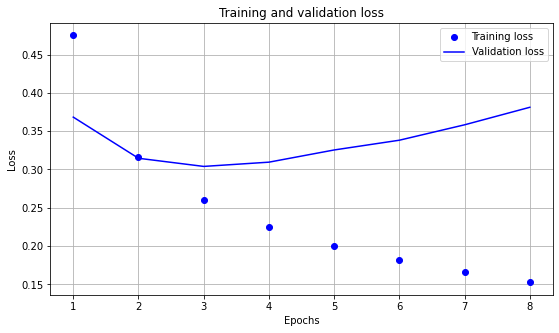

In [39]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

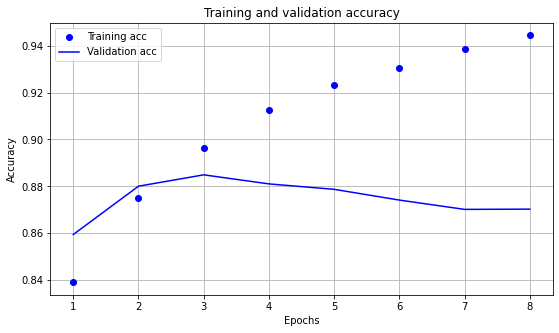

In [40]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [41]:
def print_my_examples(inputs, results, actual_values=None, limit=None):
    if actual_values is None:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}' for i in range(len(inputs))]
    else:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}\nactual value:{actual_values[i]}' for i in range(len(inputs))]
    if limit:
        result_for_printing = result_for_printing[:limit]
    print(*result_for_printing, sep='\n\n')

In [42]:
inputs = x_train[:10]
outputs = y_train[:10]
results = tf.sigmoid(model.predict(tf.constant(inputs)))
print_my_examples(inputs, results, outputs)

input:
"A 10 for designer choices"
score: 0.917489
actual value:1

input:
"Kickstarter"
score: 0.970106
actual value:1

input:
"Very enjoyable, even to the point where one can oversee the dice rolling and randomness. It is very satisfying to surround tiles that give you bonuses and to puzzle up a good end score."
score: 0.993721
actual value:1

input:
"Jugamos Una"
score: 0.994138
actual value:1

input:
"1-4"
score: 0.991019
actual value:1

input:
"2nd Edition - Kickstarted!"
score: 0.839711
actual value:1

input:
"2020.5"
score: 0.495000
actual value:1

input:
"Our first play was rather long due to the rules overload. But nevertheless it was really cinematic and great fun. Everybody had a blast. I'm really excited to play it again soon and in different constellations."
score: 0.979844
actual value:1

input:
"I enjoy this game a lot. Sometimes it can be frustrating (especially in 2 player games) as the cards you want/need don't come up, but that's life. The artwork is great and the ran

In [43]:
## APPLY MODEL ON NON-RATED COMMENTS

In [44]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(not_rated_comments.value.astype(str)))))
print_my_examples(list(not_rated_comments.value), results, limit=25)

input:
"Ordered it this morning (2/18/2021) from Amazon."
score: 0.999530

input:
"Kickstarter Project  -Backed: 04/29/2021 -Funded: 05/16/2021 -Pledge Level: Pledge $99 or more: "Boarder Only the Boarder is capable of this steal!  Limited to the first 750 backers! Get the exclusive 60mm Project X mini for FREE.  INCLUDES: Stationfall base game Miniatures Expansion Project X mini" -Payment: $99 -Projected Delivery: 12/2021 -Survey:  -Shipped:   Status: FUNDING"
score: 0.999298

input:
"Bought damaged box for extra discount from Chris."
score: 0.483236

input:
"w/ Broken Token Insert, Legendary box, metal coins"
score: 0.995547

input:
"Kan alleen met 3, maar moet heel goed zijn"
score: 0.799437

input:
"Co-op davvero intrigante; tante miniature!"
score: 0.511261

input:
"Niels Verwimp Nick Henderickx Erik Belmans Likang HUUUUUUUUU a.k.a cheaterboiiiii "
score: 0.997445

input:
"(Expansion) -Neoprene Mat -Galactic Events -Terran Ships -Rift Cannon -Extra Dice -Plastic Stands -Minor Spec

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [45]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 162886 |          8.35 |           3508 |
| 167355 |          8.41 |           1789 |
| 167791 |          8.21 |           8220 |
| 169427 |          8.59 |            219 |
| 169786 |          8.10 |           7333 |


In [46]:
not_rated_comments['rating'] = [round(float(r[0])*10, 1) for r in results]

In [47]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 162886 |          8.85 |            308 |
| 167355 |          9.15 |            217 |
| 167791 |          8.95 |            438 |
| 169427 |          8.94 |             71 |
| 169786 |          8.80 |            588 |


In [48]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [49]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/oaD1ZQ3...","<a href=""https://boardgamegeek.com/boardgame/2...",8.109434,9.570000,8.637349,1,2021
1,"<img src=""https://cf.geekdo-images.com/Zdt8l4o...","<a href=""https://boardgamegeek.com/boardgame/2...",8.313765,8.887069,8.514076,2,2021
2,"<img src=""https://cf.geekdo-images.com/SAKzHYV...","<a href=""https://boardgamegeek.com/boardgame/3...",7.000000,8.750000,8.500000,3,2022
3,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.900543,8.913433,7.988907,4,2020
4,"<img src=""https://cf.geekdo-images.com/BfEHqHQ...","<a href=""https://boardgamegeek.com/boardgame/3...",7.817670,9.121875,7.941880,5,2020


In [50]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [51]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Destinies,8.109434,9.570000,8.637349,1,2021
2,,Sleeping Gods,8.313765,8.887069,8.514076,2,2021
3,,Mosaic: A Story of Civilization,7.000000,8.750000,8.500000,3,2022
4,,Lost Ruins of Arnak,7.900543,8.913433,7.988907,4,2020
5,,Beyond the Sun,7.817670,9.121875,7.941880,5,2020


In [52]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Voidfall,10.000000,7.971429,8.225000,44,2022
2,,Hoplomachus: Victorum,10.000000,8.450000,8.671429,8,2022
3,,Chronicles of Drunagor: Age of Darkness,9.510204,8.388889,9.336207,28,2021
4,,Eclipse: Second Dawn for the Galaxy,8.744981,9.064634,8.795485,49,2020
5,,Brass: Birmingham,8.691023,9.037991,8.722729,23,2018


In [53]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Chronicles of Drunagor: Age of Darkness,9.510204,8.388889,9.336207,28,2021
2,,Eclipse: Second Dawn for the Galaxy,8.744981,9.064634,8.795485,49,2020
3,,Kemet: Blood and Sand,8.500000,8.908772,8.767816,33,2021
4,,Brass: Birmingham,8.691023,9.037991,8.722729,23,2018
5,,Stationfall,8.316667,9.353846,8.681081,15,2021


In [54]:
# model.save('saved_model\my_model')

In [55]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [56]:
# some examples on "long" comments vs short comments

In [57]:
# some long comments
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')
results = tf.sigmoid(model.predict(tf.constant(list(some_long_comments.value))))
print_my_examples(list(some_long_comments.value), results)

input:
"I was having great expectations from this title, but it fell short on implementation.  I felt bored halfway through the first game, like my decisions didn't matter as much as luck from the draw."
score: 0.060297

input:
"Opened, punched, and sorted but unplayed.  Includes Gloomhaven Town by Meeple Realty.  Not really looking to trade this, but I might consider it if the offer is good."
score: 0.482692

input:
"1x Sleeping Gods: Tides of Ruin 1x Sleeping Gods Metal Ship 1x Sleeping Gods Kickstarter Edition 1x Sleeping Gods Card Sleeve Set"
score: 0.513622

input:
"It's certainly very thematic but the fiddliness of the set up took me out.  Intentional lack of duplicate cards in the single core set also detracted from the offering."
score: 0.697068

input:
"Need to play more but so far I love the theme, art and little bird facts on the cards. The mechanics are smooth and as far as engine building goes it seems to be a big step up from something like Splendor."
score: 0.743794

inp